# Sentiment Analysis

### Imports

In [111]:
import pandas as pd
import os
import csv
import logging
import numpy as np
import datetime as datetime
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from happytransformer import HappyTextClassification # https://happytransformer.com/
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import mode as mode
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [2]:
df = pd.read_pickle('./data/df_processed.pickle')
len(df)

365031

In [3]:
df.head(1).append(df.tail(1))

,author,date,domain,title,url,content,topic_area,content_processed
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...
369046,NaN,2020-12-31,marketscreener,FTSE 100 wraps up worst year since 2008 financ...,https://www.marketscreener.com/quote/index/FTS...,"The FTSE 100 lost 1.5%, with consumer stocks, ...",business,ftse lost consumer stocks mainly unilever diag...


# Distilbert
https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english

In [4]:
process = False

if process:
    
    distilbert = HappyTextClassification("DISTILBERT", "distilbert-base-uncased-finetuned-sst-2-english", num_labels=2)

    df['distilbert'] = ''
    col_num = df.columns.get_loc('distilbert')

    for idx, title in tqdm(enumerate(df['title'])):
        if not pd.isnull(title):
            if len(title.split(" ")) < 512:
                label = distilbert.classify_text(title).label
                df.iloc[idx, col_num] = label
            else:
                df.iloc[idx, col_num] = "TOO_LONG"
        else:
            df.iloc[idx, col_num] = ""

08/27/2021 20:29:36 - INFO - happytransformer.happy_transformer -   Using model: cuda


In [5]:
print(distilbert.classify_text("I am blue"))
print(distilbert.classify_text("I love candy"))
print(distilbert.classify_text("I hate candy"))

TextClassificationResult(label='POSITIVE', score=0.9037488102912903)
TextClassificationResult(label='POSITIVE', score=0.9998459815979004)
TextClassificationResult(label='NEGATIVE', score=0.9976422190666199)


# Finbert
https://huggingface.co/ProsusAI/finbert

In [10]:
process = False

if process:

    finbert = HappyTextClassification("FINBERT", "ProsusAI/finbert", num_labels=3)

    df['finbert'] = ''
    col_num = df.columns.get_loc('finbert')

    for idx, title in tqdm(enumerate(df['title'])):
        if not pd.isnull(title):
            if len(title.split(" ")) < 512:
                label = finbert.classify_text(title).label
                df.iloc[idx, col_num] = label
            else:
                df.iloc[idx, col_num] = "TOO_LONG"
        else:
            df.iloc[idx, col_num] = ""

08/27/2021 21:16:51 - INFO - happytransformer.happy_transformer -   Using model: cuda
365200it [1:06:07, 92.05it/s] 


# Roberta
https://huggingface.co/roberta-large-mnli

In [9]:
process = False

if process:

roberta = HappyTextClassification("ROBERTA", "siebert/sentiment-roberta-large-english", num_labels=2)

    df['roberta'] = ''
    col_num = df.columns.get_loc('roberta')

    for idx, title in tqdm(enumerate(df['title'])):
        if not pd.isnull(title):
            if len(title.split(" ")) < 512:
                label = roberta.classify_text(title).label
                df.iloc[idx, col_num] = label
            else:
                df.iloc[idx, col_num] = "TOO_LONG"
        else:
            df.iloc[idx, col_num] = ""

08/28/2021 16:56:33 - INFO - happytransformer.happy_transformer -   Using model: cuda
365200it [1:54:58, 52.94it/s]


### Save/Load Sentiment Rankings

In [76]:
process_sentiment = False

if process_sentiment:
    df.to_pickle('./data/df_sentiment.pickle')
else:
    df = pd.read_pickle('./data/df_sentiment.pickle')
    df['finbert'] = df['finbert'].str.upper()
    print(len(df))

365200


In [87]:
#df_cm = df[(df['distilbert'] != "") & (df['distilbert'] != "TOO_LONG") & (df['distilbert'] != "too_long")]
df_sent = df.copy()

# most common sentiment
df_sent['sentiment'] = df_sent.apply(lambda x: mode([x['distilbert'], x['finbert'], x['roberta']])[0][0], axis=1)
print(len(df_sent))

# drop blank titles
df_sent = df_sent[~pd.isna(df_sent["title"])]
df_sent = df_sent[df_sent["sentiment"] != "too_long"]

# sentiment match
sentiment_match = np.array(df_sent[['finbert', 'distilbert', 'roberta']])
sentiment_match = np.all(np.equal(sentiment_match, sentiment_match[:,:1]), axis=1)
df_sent['sentiment_match'] = sentiment_match

365200


In [88]:
df_sent.head(1).append(df_sent.tail(1))

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment,sentiment_match
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,POSITIVE,NEUTRAL,POSITIVE,POSITIVE,False
369046,NaN,2020-12-31,marketscreener,FTSE 100 wraps up worst year since 2008 financ...,https://www.marketscreener.com/quote/index/FTS...,"The FTSE 100 lost 1.5%, with consumer stocks, ...",business,ftse lost consumer stocks mainly unilever diag...,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,True


# Analysis of sentiment labels

In [80]:
dist = pd.DataFrame(df_sent['distilbert'].value_counts())
fin = df_sent['finbert'].value_counts()
rob = df_sent['roberta'].value_counts()
labels = pd.concat([dist, fin, rob], axis=1)
labels = labels.fillna(0).astype(int)
labels

,distilbert,finbert,roberta
NEGATIVE,233689,105979,163063
POSITIVE,131425,60771,202051
NEUTRAL,0,198364,0


In [81]:
labels.T.div(labels.T.sum(axis=1), axis=0)

,NEGATIVE,POSITIVE,NEUTRAL
distilbert,0.640044,0.359956,0.000000
finbert,0.290263,0.166444,0.543293
roberta,0.446608,0.553392,0.000000


/home/ubuntu/thesis_env2/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
<ipython-input-82-2c78c43cac96>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
<ipython-input-82-2c78c43cac96>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:.0%}'.format(float(x)) for x in ax2.get_yticks().tolist()])


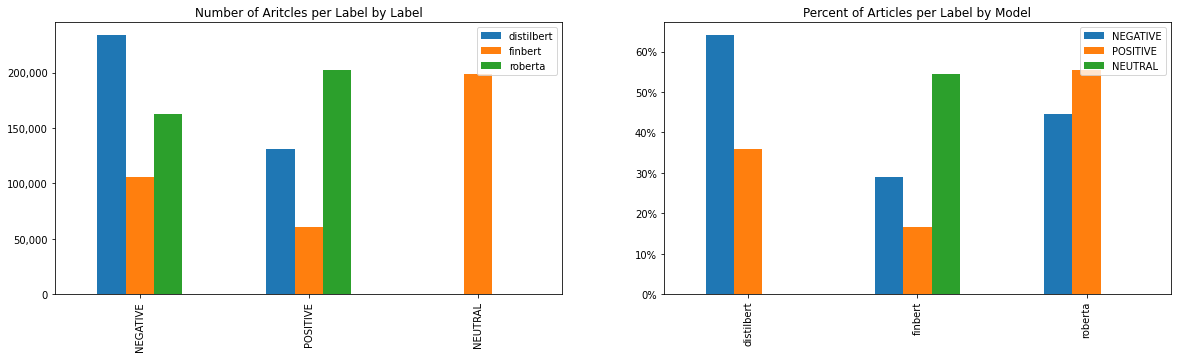

In [82]:
labels_percent = labels.T.div(labels.T.sum(axis=1), axis=0)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))
labels.plot(kind='bar', ax=ax1)
labels_percent.plot(kind='bar', ax=ax2)
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
ax2.set_yticklabels(['{:.0%}'.format(float(x)) for x in ax2.get_yticks().tolist()])
ax1.set_title('Number of Aritcles per Label by Label')
ax2.set_title('Percent of Articles per Label by Model')
None

In [83]:
cm = pd.DataFrame(confusion_matrix(df_sent['finbert'], df_sent['distilbert'], labels=['NEGATIVE', 'POSITIVE', 'NEUTRAL']), 
             columns=['NEGATIVE', 'POSITIVE', 'NEUTRAL'],
             index=['NEGATIVE', 'POSITIVE', 'NEUTRAL'])
cm['TOTAL'] = cm.sum(axis=1)
cm.loc['TOTAL']= cm.sum()
cm

,NEGATIVE,POSITIVE,NEUTRAL,TOTAL
NEGATIVE,98357,7622,0,105979
POSITIVE,24353,36418,0,60771
NEUTRAL,110979,87385,0,198364
TOTAL,233689,131425,0,365114


In [84]:
cm = pd.DataFrame(confusion_matrix(df_sent['finbert'], df_sent['roberta'], labels=['NEGATIVE', 'POSITIVE', 'NEUTRAL']), 
             columns=['NEGATIVE', 'POSITIVE', 'NEUTRAL'],
             index=['NEGATIVE', 'POSITIVE', 'NEUTRAL'])
cm['TOTAL'] = cm.sum(axis=1)
cm.loc['TOTAL']= cm.sum()
cm

,NEGATIVE,POSITIVE,NEUTRAL,TOTAL
NEGATIVE,90854,15125,0,105979
POSITIVE,8011,52760,0,60771
NEUTRAL,64198,134166,0,198364
TOTAL,163063,202051,0,365114


In [85]:
cm = pd.DataFrame(confusion_matrix(df_sent['distilbert'], df_sent['roberta'], labels=['NEGATIVE', 'POSITIVE']), 
             columns=['NEGATIVE', 'POSITIVE'],
             index=['NEGATIVE', 'POSITIVE'])
cm['TOTAL'] = cm.sum(axis=1)
cm.loc['TOTAL']= cm.sum()
cm

,NEGATIVE,POSITIVE,TOTAL
NEGATIVE,145922,87767,233689
POSITIVE,17141,114284,131425
TOTAL,163063,202051,365114


In [90]:
df_sent_match = df_cm[df_cm['sentiment_match'] == True]
len(df_sent_match)

121002

# Manually Determined Sentiment Labels

In [91]:
# Get index numbers of articles to label
df_for_index = pd.read_pickle('./data/bigrams/df_processed_bigrams_top2vec_trg.pickle')
#df_for_index = pd.read_pickle('./data/df_processed.pickle')
print(len(df))

np.random.seed(777)
article_indices = np.random.choice(df_for_index.index, size=1000, replace=False)
print(article_indices[:10])

# Export articles to label in excel for easier review
#df.loc[article_indices, "title"].to_csv("df_titles_to_sent_label.csv")

365200
[  8360 140259 359873 152617 339686  63962 239603   6951 320211 363304]


In [92]:
# Import labeled articles

df_sent_labels = pd.read_csv("df_titles_to_sent_label.csv")
df_sent_labels = df_sent_labels[df_sent_labels["title"].notna()]
df_sent_labels = df_sent_labels.fillna(0)
df_sent_labels["Neutral"] = df_sent_labels["Neutral"].astype(int)
df_sent_labels["Unconfident"] = df_sent_labels["Unconfident"].astype(int)

with pd.option_context('display.max_colwidth', 400):
    display(df_sent_labels[:10])

,df_idx,title,Pos_Neg,Neutral,Unconfident
0,8360,"What’s After Coronavirus? Stocks Could Drop, and Then Surge",1,1,0
1,140259,Biden on verge of clinching Democratic nomination,1,0,0
2,359873,Virgin Galactic aborts first powered spaceflight from New Mexico spaceport,0,0,0
3,152617,Scrub that: Pandemic forces ship owners to shelve anti-pollution gear,0,0,0
4,339686,Regeneron hopes U.S. will authorize coronavirus antibody drug soon,1,0,0
5,63962,Easter greetings and traditions: How to celebrate Good Friday and Easter this weekend,1,0,0
6,239603,AUD holds onto gains; Is the US dollar bull run coming to an end?,1,1,0
7,6951,Investors need to face the warning signs in the global economy,0,0,0
8,320211,Australis Capital : Concerned Australis Shareholders Outline Strategy to Grow Core Cannabis Business and Preserve Shareholder Value,1,0,0
9,363304,Stock market briefly hits records as Wall Street kicks off trade in quadruple-witching Friday; Tesla set to enter the S&P 500,1,0,0


## Testing of models on labeled dataset

In [93]:
# Load Labeled Data
df_sent_labels = pd.read_csv("df_titles_to_sent_label.csv", index_col="df_idx")
#df_sent_labels = pd.read_csv("df_titles_to_sent_label.csv")
df_sent_labels = df_sent_labels[df_sent_labels["title"].notna()]
df_sent_labels = df_sent_labels.fillna(0)
df_sent_labels["Neutral"] = df_sent_labels["Neutral"].astype(int)
df_sent_labels["Unconfident"] = df_sent_labels["Unconfident"].astype(int)
df_sent_labels["Sent_lab_Pos_Neg"] = df_sent_labels["Pos_Neg"].replace({1: "POSITIVE", 0: "NEGATIVE"})
df_sent_labels["Sent_lab_Neutral"] = df_sent_labels.apply(lambda row: np.where(row["Neutral"] == 1, str("NEUTRAL"), str(row["Sent_lab_Pos_Neg"])), axis=1)
df_sent_labels["Sent_lab_Neutral"] = df_sent_labels["Sent_lab_Neutral"].astype(str)
df_sent_labels

,title,Pos_Neg,Neutral,Unconfident,Sent_lab_Pos_Neg,Sent_lab_Neutral
df_idx,,,,,,
8360,"What’s After Coronavirus? Stocks Could Drop, a...",1,1,0,POSITIVE,NEUTRAL
140259,Biden on verge of clinching Democratic nomination,1,0,0,POSITIVE,POSITIVE
359873,Virgin Galactic aborts first powered spaceflig...,0,0,0,NEGATIVE,NEGATIVE
152617,Scrub that: Pandemic forces ship owners to she...,0,0,0,NEGATIVE,NEGATIVE
339686,Regeneron hopes U.S. will authorize coronaviru...,1,0,0,POSITIVE,POSITIVE
...,...,...,...,...,...,...
101824,Ascendis Pharma A/S Announces First Quarter 20...,1,1,0,POSITIVE,NEUTRAL
258442,Thai exports may shrink by 15% this year: ship...,0,0,0,NEGATIVE,NEGATIVE
311039,FedEx Flexes Pricing Muscle on E-Commerce Surg...,1,0,0,POSITIVE,POSITIVE


In [94]:
# Add ground truth labels to model determined data
df_sent_check = df_sent.loc[df_sent_labels.index]
df_sent_check = df_sent_check.merge(right=df_sent_labels[["Sent_lab_Pos_Neg", "Sent_lab_Neutral"]], left_index=True, right_index=True)
df_sent_check.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment,sentiment_match,Sent_lab_Pos_Neg,Sent_lab_Neutral
df_idx,,,,,,,,,,,,,,,
8360,Nicholas Jasinski,2020-02-26,marketwatch,"What’s After Coronavirus? Stocks Could Drop, a...",https://www.marketwatch.com/articles/whats-aft...,Photograph by Noel Celis/AFP via Getty Images ...,business,photograph noel celisafp getty images stocks c...,NEGATIVE,NEGATIVE,POSITIVE,NEGATIVE,False,POSITIVE,NEUTRAL


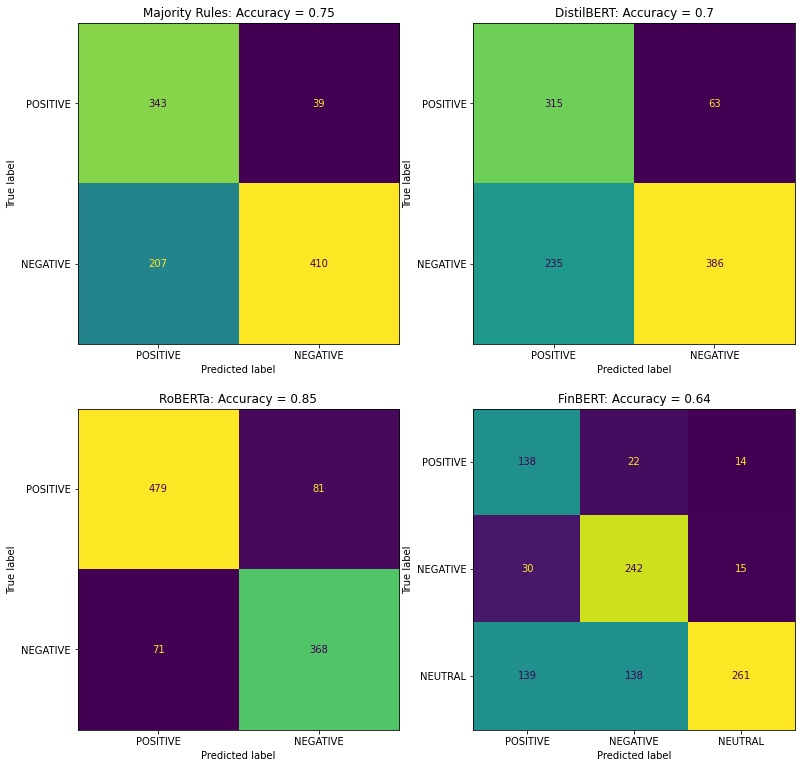

In [135]:
# Accuracy
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(13,13))
labels = ["POSITIVE", "NEGATIVE"]
conf_mat = confusion_matrix(df_sent_check['sentiment'], df_sent_check['Sent_lab_Pos_Neg'], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
disp.plot(ax=ax1, colorbar=False)
total_agree = conf_mat.ravel()[0] + conf_mat.ravel()[3]
accuracy = round(total_agree / 999, 2)
ax1.set_title(f'Majority Rules: Accuracy = {accuracy}')

labels = ["POSITIVE", "NEGATIVE"]
conf_mat = confusion_matrix(df_sent_check['distilbert'], df_sent_check['Sent_lab_Pos_Neg'], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
disp.plot(ax=ax2, colorbar=False)
total_agree = conf_mat.ravel()[0] + conf_mat.ravel()[3]
accuracy = round(total_agree / 999, 2)
ax2.set_title(f'DistilBERT: Accuracy = {accuracy}')

labels = ["POSITIVE", "NEGATIVE"]
conf_mat = confusion_matrix(df_sent_check['roberta'], df_sent_check['Sent_lab_Pos_Neg'], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
disp.plot(ax=ax3, colorbar=False)
total_agree = conf_mat.ravel()[0] + conf_mat.ravel()[3]
accuracy = round(total_agree / 999, 2)
ax3.set_title(f'RoBERTa: Accuracy = {accuracy}')

labels = ["POSITIVE", "NEGATIVE", "NEUTRAL"]
conf_mat = confusion_matrix(df_sent_check['finbert'], df_sent_check['Sent_lab_Neutral'], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
disp.plot(ax=ax4, colorbar=False)
total_agree = conf_mat.ravel()[0] + conf_mat.ravel()[4] + conf_mat.ravel()[8]
accuracy = round(total_agree / 999, 2)
ax4.set_title(f'FinBERT: Accuracy = {accuracy}')

plt.show()

# Transformers on Equintel Test Set 

In [5]:
DATA_DIR = "/home/ubuntu/thesis/Thesis/equintel_model"
TESTSET = pd.read_csv(os.path.join(DATA_DIR, "sentiment_testset.csv"))
TESTSET.head(1)

,text,label
0,"U.S. West hit with extreme heat, drought and u...",0


In [17]:
df_equintel = TESTSET.copy()

distilbert = HappyTextClassification("DISTILBERT", "distilbert-base-uncased-finetuned-sst-2-english", num_labels=2)
finbert = HappyTextClassification("FINBERT", "ProsusAI/finbert", num_labels=3)
roberta = HappyTextClassification("ROBERTA", "siebert/sentiment-roberta-large-english", num_labels=2)

df_equintel['distilbert'] = ''
df_equintel['finbert'] = ''
df_equintel['roberta'] = ''
col_num_d = df_equintel.columns.get_loc('distilbert')
col_num_f = df_equintel.columns.get_loc('finbert')
col_num_r = df_equintel.columns.get_loc('roberta')

for idx, title in tqdm(enumerate(df_equintel['text'])):
    if not pd.isnull(title):
        if len(title.split(" ")) < 512:
            label_d = distilbert.classify_text(title).label
            label_f = finbert.classify_text(title).label
            label_r = roberta.classify_text(title).label
            df_equintel.iloc[idx, col_num_d] = label_d
            df_equintel.iloc[idx, col_num_f] = label_f
            df_equintel.iloc[idx, col_num_r] = label_r
        else:
            df_equintel.iloc[idx, col_num_d] = "TOO_LONG"
            df_equintel.iloc[idx, col_num_f] = "TOO_LONG"
            df_equintel.iloc[idx, col_num_r] = "TOO_LONG"
    else:
        df_equintel.iloc[idx, col_num_d] = ""
        df_equintel.iloc[idx, col_num_f] = ""
        df_equintel.iloc[idx, col_num_r] = ""
        

11/06/2021 14:43:46 - INFO - happytransformer.happy_transformer -   Using model: cuda
11/06/2021 14:43:52 - INFO - happytransformer.happy_transformer -   Using model: cuda
11/06/2021 14:44:01 - INFO - happytransformer.happy_transformer -   Using model: cuda
2000it [00:57, 34.83it/s]


In [22]:
df_equintel["finbert"] = df_equintel["finbert"].str.upper()
df_equintel["equintel"] = df_equintel["label"].replace({0: "NEGATIVE", 1: "POSITIVE"})
df_equintel

,text,label,distilbert,finbert,roberta,equintel
0,"U.S. West hit with extreme heat, drought and u...",0,NEGATIVE,NEGATIVE,POSITIVE,NEGATIVE
1,California and Arizona wildfires spread as dro...,0,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE
2,"Wildfires rage in California, stoked by extrem...",0,POSITIVE,NEGATIVE,POSITIVE,NEGATIVE
3,California drought: This sumer was the most ex...,0,NEGATIVE,NEUTRAL,POSITIVE,NEGATIVE
4,Monitoring the Arctic Heatwave: Alarmingly Hig...,0,NEGATIVE,NEGATIVE,POSITIVE,NEGATIVE
...,...,...,...,...,...,...
1995,ESG Clarity and DiversityQ team up with reboot...,1,POSITIVE,NEUTRAL,POSITIVE,POSITIVE
1996,Rio Tinto: targets low-carbon steel production...,1,POSITIVE,NEUTRAL,POSITIVE,POSITIVE
1997,Rio Tinto targets low-carbon steel production ...,1,POSITIVE,NEUTRAL,POSITIVE,POSITIVE
1998,Aemetis and Koch Project Solutions Select Worl...,1,POSITIVE,POSITIVE,POSITIVE,POSITIVE


In [23]:
df_equintel.to_csv("df_equintel_transformers.csv")